In [1]:
!pip install outlines
!pip install typing
!pip install pydantic
!pip3 install torch==2.3.1
!pip install PyMuPDF
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes
!pip install llama-cpp-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 1.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 763.2 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=395ec4b778cbfa9c05d33ff342cd06a80fe55b20eac88077ee9a2e0fda12caa7
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:0000:0100:09m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta

In [2]:
import torch
print(torch.cuda.is_available())

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [3]:
from unsloth import FastLanguageModel

max_seq_length = 2048 # was 2048
dtype = None
load_in_4bit = True

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = secret_value_0
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2024-08-27 17:29:45.640828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 17:29:45.640937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 17:29:45.807265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,
    target_modules = ["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    lora_alpha = 8, # changed from 16
    lora_dropout = 0, # for faster training
    bias = "none", # for faster training
    use_gradient_checkpointing= "unsloth",
    use_rslora = True, # modifies scaling factor for LoRa adapters
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
from datasets import load_dataset

ds = load_dataset(
    "HuggingFaceM4/Docmatix",
    "pdf",
    streaming = True,
    split = "train"
)

Resolving data files:   0%|          | 0/1106 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/918 [00:00<?, ?it/s]

In [6]:
SampleData1 = iter(ds)
total_read = 1000 # was 15000
PartialList = list()
for i in range(total_read):
    PartialList.append(next(SampleData1)) # Can not get the entire dataset so streaming to get only a few entries (10000)

In [7]:
import pandas as pd

df = pd.DataFrame(PartialList)

df.head()

,pdf,texts
0,b'%PDF-1.4\n%\xaa\xab\xac\xad\n1 0 obj\n<<\n/T...,[{'user': 'What is the purpose of the Confirma...
1,b'%PDF-1.4\r%\xe2\xe3\xcf\xd3\r\n167 0 obj\r<<...,[{'user': 'What is the summary of the provided...
2,b'%PDF-1.7\n%\xe2\xe3\xcf\xd3\n10 0 obj\n<< /T...,"[{'user': 'What is the main topic of the ""Cupc..."
3,b'%PDF-1.3\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Len...,[{'user': 'What is the purpose of the Special ...
4,b'%PDF-1.7\n%\xe2\xe3\xcf\xd3\n10 0 obj\n<< /T...,[{'user': 'What is the title of the book menti...


In [8]:
df['texts'][0][1]

{'user': 'When was the filing received as per the document?',
 'assistant': 'The filing was received for filing in Electronic Format on the 23/03/2021.',
 'source': 'PDFA key: 244'}

In [9]:
from pydantic import BaseModel
from typing import List
from io import BytesIO

import fitz
import re

class SampleStructure(BaseModel):
    assistant:str
        
def addPdfText(row):
    try:
        pdf_stream = BytesIO(row['pdf'])
        doc = fitz.open(stream=pdf_stream, filetype="pdf")
        extracted_text = ""

        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            text = page.get_text("text")
            extracted_text += text

        doc.close()
        
        extracted_text = re.sub(r'[^A-Za-z0-9\s]', '', extracted_text)
        return extracted_text
    except:
        return ""
    
def addUserQuestion(row):
    query = row['texts'][0]['user']
    
    return query

def addAssistantAnswer(row):
    answer = row['texts'][0]['assistant']
    
    return answer

df['pdftotext'] = df.apply(addPdfText,axis=1)
df['userQuery'] = df.apply(addUserQuestion, axis=1)
df['assistantAnswer'] = df.apply(addAssistantAnswer, axis=1)

MuPDF error: format error: No default Layer config



In [10]:
df.head()

,pdf,texts,pdftotext,userQuery,assistantAnswer
0,b'%PDF-1.4\n%\xaa\xab\xac\xad\n1 0 obj\n<<\n/T...,[{'user': 'What is the purpose of the Confirma...,CS01ef\n \nConfirmation Statement\n \nCompany ...,What is the purpose of the Confirmation Statem...,The purpose of the Confirmation Statement is t...
1,b'%PDF-1.4\r%\xe2\xe3\xcf\xd3\r\n167 0 obj\r<<...,[{'user': 'What is the summary of the provided...,CHRISTIAN\nCOUNSELING\nSome local counselors w...,What is the summary of the provided text?,The provided text is a list of Christian couns...
2,b'%PDF-1.7\n%\xe2\xe3\xcf\xd3\n10 0 obj\n<< /T...,"[{'user': 'What is the main topic of the ""Cupc...",Get Free Cupcakes And Cashmere A Guide For Def...,"What is the main topic of the ""Cupcakes and Ca...","The main topic of the ""Cupcakes and Cashmere"" ..."
3,b'%PDF-1.3\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Len...,[{'user': 'What is the purpose of the Special ...,\n Special Exception Request Applicat...,What is the purpose of the Special Exception R...,The purpose of the Special Exception Request A...
4,b'%PDF-1.7\n%\xe2\xe3\xcf\xd3\n10 0 obj\n<< /T...,[{'user': 'What is the title of the book menti...,Read Free Microbiology Lab Theory And Applicat...,What is the title of the book mentioned in the...,The title of the book mentioned in the text is...


In [11]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


EOS_TOKEN = tokenizer.eos_token
def preprocessData(examples):
    Inputs = examples['pdftotext']
    UsersQueries = examples['userQuery']
    Responses = examples["assistantAnswer"]
    texts = []
    for Inp, Queries,Resp in zip(Inputs,UsersQueries,Responses):
        text = prompt.format(Queries,Inp,Resp) + EOS_TOKEN
        texts.append(text)
        
    return {"text":texts,}

FormattedPrompt = preprocessData(df)

In [12]:
from datasets import Dataset
FormattedPrompt = Dataset.from_dict(FormattedPrompt)
print(type(FormattedPrompt))

<class 'datasets.arrow_dataset.Dataset'>


In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported


trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=FormattedPrompt,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False, # WAS FALSE
    args=TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=1,
        warmup_steps=10,
        num_train_epochs = 6,
        learning_rate=4e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=100,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        output_dir="outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
secret_value_1 = user_secrets.get_secret("WANDB_API_KEY")
!wandb login $secret_value_1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 6
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 1
\        /    Total batch size = 4 | Total steps = 1,500
 "-____-"     Number of trainable parameters = 20,971,520
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,2.060100
200,2.026300
300,1.847100
400,1.732400
500,1.729400
600,1.330100
700,1.322800
800,1.122100
900,0.933100
1000,0.938900


In [16]:
IndexToCheck = 55
FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    prompt.format(
        df['userQuery'][IndexToCheck],
        df['pdftotext'][IndexToCheck],
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is the Nclex Secrets Study Guide focused on?

### Input:
Nclex Secrets Study Guide
NCLEXRN Test Study Guide NCLEXRN Secrets Study Guide PDF Free Download  Medical  Nclex rn
secrets study guide pdf  Guangdong Gresat House Co Free Download NCLEXRN Secrets Study Guide
NCLEX Test  NCLEXRN SECRETS STUDY GUIDE PDF FREE DOWNLOAD2021  Nclex Study
Guide  eventsupeduph Nclex Rn Secrets Study Guide Nclex Test Review For The  NCLEXRN
Examination  NCSBN Nclex Secrets Study Guide Need to know medications for NCLEX Nclex Secrets Study
Guide NCLEX Secrets Study Guide  mometrixcom Illustrated Study Guide For The Nclex Rn Exam Pdf
NCLEX RN 2020 and 2021 Secrets Study Guide by Mometrix  NCLEX Study Guide NCLEX Prep NCLEX
Review Course Nclex rn secrets study guide pdf  Guangdong Gresat House Co Secret To Answer

In [17]:
print(df["assistantAnswer"][IndexToCheck])

The Nclex Secrets Study Guide is focused on helping individuals pass the National Council Licensure Examination for Registered Nurses (NCLEX-RN).


In [18]:
HfToken = user_secrets.get_secret("FULL_HF_TOKEN")
model.push_to_hub("mobeen0/docmatixFinetune3", token = HfToken)

README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

Saved model to https://huggingface.co/mobeen0/docmatixFinetune3


In [19]:
df = pd.DataFrame(trainer.state.log_history)
df

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.0601,0.705575,3.758389e-04,0.4,100,NaN,NaN,NaN,NaN,NaN
1,2.0263,0.809117,3.489933e-04,0.8,200,NaN,NaN,NaN,NaN,NaN
2,1.8471,1.297742,3.221477e-04,1.2,300,NaN,NaN,NaN,NaN,NaN
3,1.7324,1.052017,2.953020e-04,1.6,400,NaN,NaN,NaN,NaN,NaN
4,1.7294,1.018959,2.684564e-04,2.0,500,NaN,NaN,NaN,NaN,NaN
5,1.3301,1.148031,2.416107e-04,2.4,600,NaN,NaN,NaN,NaN,NaN
6,1.3228,1.208868,2.147651e-04,2.8,700,NaN,NaN,NaN,NaN,NaN
7,1.1221,1.078029,1.879195e-04,3.2,800,NaN,NaN,NaN,NaN,NaN
8,0.9331,1.548195,1.610738e-04,3.6,900,NaN,NaN,NaN,NaN,NaN
9,0.9389,1.380499,1.344966e-04,4.0,1000,NaN,NaN,NaN,NaN,NaN


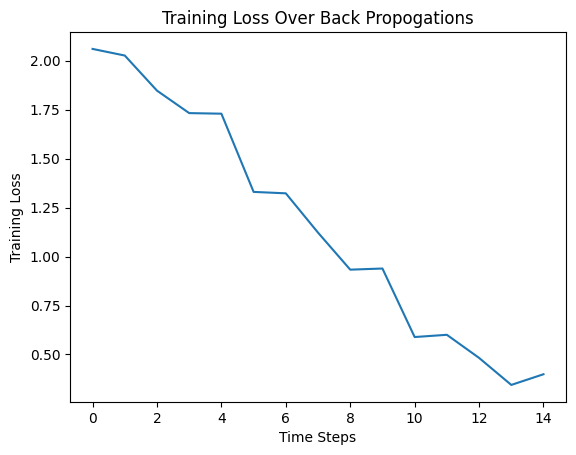

In [20]:
import matplotlib.pyplot as plt
X_vals = range(len(df))
y_loss = df['loss']


plt.plot(X_vals, y_loss)
plt.xlabel('Time Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Back Propogations')
plt.show()